In [4]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 

from darts import TimeSeries 
from darts.dataprocessing.transformers import Diff
from darts.utils.statistics import stationarity_test_adf
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from darts.models.forecasting.arima import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
from pmdarima.arima import auto_arima 

from darts.metrics import mae, mape
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

import warnings 
warnings.filterwarnings('ignore')

In [5]:
df = pd.read_csv('/Users/kelvinfoo/Desktop/AI Masters/Hospital Admission Time Series/hospital_admission.csv')
df = df.rename(columns = {'Data Series':'Date', 'Public Sector Hospital Admissions -> Alexandra Hospital (Number)': 'Alexandra Hospital', 
                     'Public Sector Hospital Admissions -> Changi General Hospital (Number)':'Changi General Hospital', 
                     'Public Sector Hospital Admissions -> Khoo Teck Puat Hospital (Number)':'Khoo Teck Puat Hospital', 
                     'Public Sector Hospital Admissions -> National University Hospital (Number)': 'National University Hospital', 
                     'Public Sector Hospital Admissions -> Sengkang General Hospital (Number)': 'Sengkang General Hospital'})

df['Date'] = pd.to_datetime(df['Date'])
df = df[['Date', 'Alexandra Hospital', 'Changi General Hospital', 'Khoo Teck Puat Hospital', 'National University Hospital', 'Sengkang General Hospital']]
df = df[df['Date'] >= '2020-01-01']

df['Alexandra Hospital'] = df['Alexandra Hospital'].astype('int64')
df['Changi General Hospital'] = df['Changi General Hospital'].astype('int64')
df['Khoo Teck Puat Hospital'] = df['Khoo Teck Puat Hospital'].astype('int64')
df['National University Hospital'] = df['National University Hospital'].astype('int64')
df['Sengkang General Hospital'] = df['Sengkang General Hospital'].astype('int64')
df.set_index('Date', inplace = True)

df = df.sort_values(by = 'Date', ascending = True)

In [6]:
def split_dataset(df, hospital): 
    hospital_df = df[hospital]
    ts_hospital_train = TimeSeries.from_series(hospital_df[:58]) 
    ts_hospital_test = TimeSeries.from_series(hospital_df[58:])
    return ts_hospital_train, ts_hospital_test

### **ARIMA Forecasting (Alexandra Hospital)**

p-value: 0.0


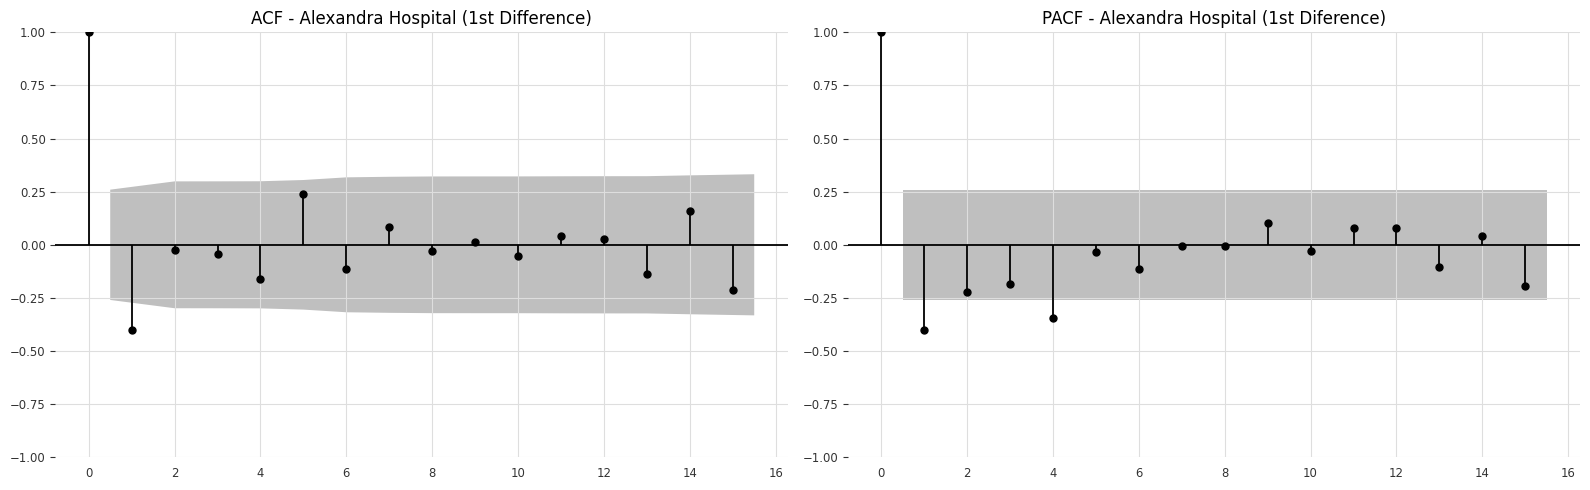

In [7]:
alexandra_train, alexandra_test = split_dataset(df, 'Alexandra Hospital')

# Perform differencing to make ts stationary 
differencer = Diff(lags = 1, dropna = True)
alexandra_train_first_diff = differencer.fit_transform(alexandra_train)
adf_result = stationarity_test_adf(alexandra_train_first_diff)
print(f"p-value: {round(adf_result[1], 3)}") # d = 1 in ARIMA model 

# plot acf and pacf 
fig, axes = plt.subplots(1, 2, figsize = (16, 5))
plot_acf(alexandra_train_first_diff.pd_series(), lags = 15, alpha = 0.05, ax = axes[0])
axes[0].set_title("ACF - Alexandra Hospital (1st Difference)")

plot_pacf(alexandra_train_first_diff.pd_series(), lags = 15, alpha = 0.05, ax = axes[1])
axes[1].set_title("PACF - Alexandra Hospital (1st Diference)")

plt.tight_layout()
plt.show() # ARIMA(1,1,1)

In [29]:
# Forecast using ARIMA(1,1,1)
model = ARIMA(p = 1, d = 1, q = 1)
model.fit(alexandra_train)
alexandra_pred = model.predict(4)

alexandra_mae = mae(alexandra_pred, alexandra_test)
alexandra_mape = mape(alexandra_test, alexandra_pred)

print(f"MAE (Test Only): {alexandra_mae:.2f}")
print(f"MAPE (Test Only): {alexandra_mape:.2f}%\n")


MAE (Test Only): 66.08
MAPE (Test Only): 6.51%



MAE (Test Only): 51.62
MAPE (Test Only): 5.06%



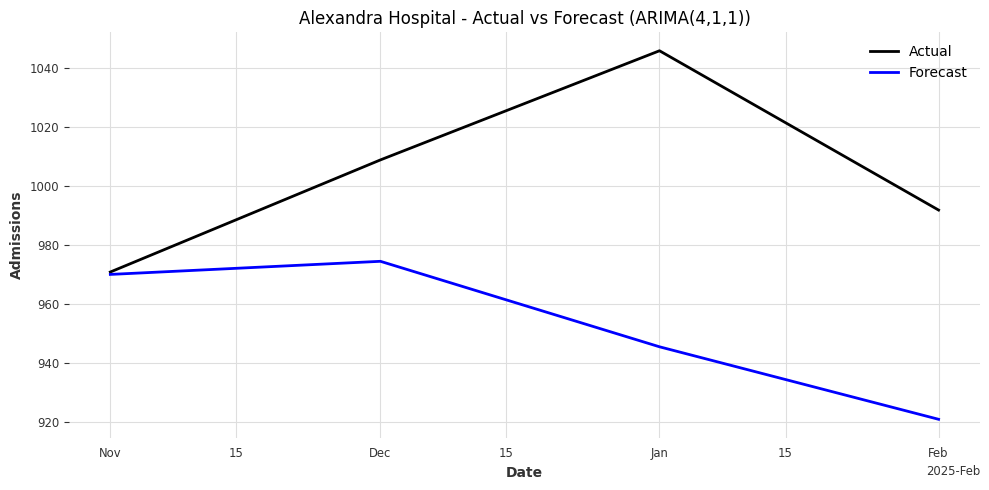

In [55]:
# Forecast using ARIMA(4,1,1)
model = ARIMA(p = 4, d = 1, q = 1)
model.fit(alexandra_train)
alexandra_pred = model.predict(4)

alexandra_mae = mae(alexandra_pred, alexandra_test)
alexandra_mape = mape(alexandra_test, alexandra_pred)

print(f"MAE (Test Only): {alexandra_mae:.2f}")
print(f"MAPE (Test Only): {alexandra_mape:.2f}%\n")

plt.figure(figsize=(10, 5))
alexandra_test.plot(label="Actual", color="black")
alexandra_pred.plot(label="Forecast", color="blue")
plt.title("Alexandra Hospital - Actual vs Forecast (ARIMA(4,1,1))")
plt.xlabel("Date")
plt.ylabel("Admissions")
plt.legend()
plt.tight_layout()
plt.show()


In [60]:
residuals = alexandra_test.pd_series() - alexandra_pred.pd_series()

lb_test = acorr_ljungbox(residuals.dropna(), lags = 3, return_df = True) 
print(f"p-value of Ljung-box test: {lb_test['lb_pvalue'].iloc[0]}")

p-value of Ljung-box test: 0.6234020664473505


In [9]:
alexandra_auto_arima = auto_arima(alexandra_train.pd_series(), start_p = 1, start_q = 1, max_p = 5, max_q = 5, 
                                  d = 1, max_d = 2, D = 1, max_D = 2, start_P = 0, start_Q = 0, max_P = 2, max_Q = 2,
                                  seasonal = True, information_criterion = 'aic', stepwise = True, random_state = 42, trace = True)

alexandra_auto_arima.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=680.694, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=695.726, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=687.754, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=679.369, Time=0.01 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=693.874, Time=0.00 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=680.710, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=682.244, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=678.693, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=680.274, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=680.260, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=686.040, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=681.658, Time=0.02 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.203 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   58
Model:               SARIMAX(0, 1, 1)   Log Likelihood                -337.346
Date:                Wed, 16 Apr 2025   AIC                            678.693
Time:                        09:56:48   BIC                            682.779
Sample:                    01-01-2020   HQIC                           680.281
                         - 10-01-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6644      0.099     -6.678      0.000      -0.859      -0.469
sigma2      8002.2525   1629.691      4.910      0.000    4808.117    1.12e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):                 0.24
Prob(Q):                              0.78   Prob(JB):                         0.89
Heteroskedasticity (H):               0.87   Skew:                             0.03
Prob(H) (two-sided):                  0.77   Kurtosis:                         2.69
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [10]:
# Forecast using ARIMA(0,1,1)
model = ARIMA(p = 0, d = 1, q = 1)
model.fit(alexandra_train)
alexandra_pred = model.predict(4)

alexandra_mae = mae(alexandra_pred, alexandra_test)
alexandra_mape = mape(alexandra_test, alexandra_pred)

print(f"MAE (Test Only): {alexandra_mae:.2f}")
print(f"MAPE (Test Only): {alexandra_mape:.2f}%\n")

MAE (Test Only): 68.90
MAPE (Test Only): 6.79%



### **ARIMA Forecasting (Changi General Hospital)**

p-value: 0.002


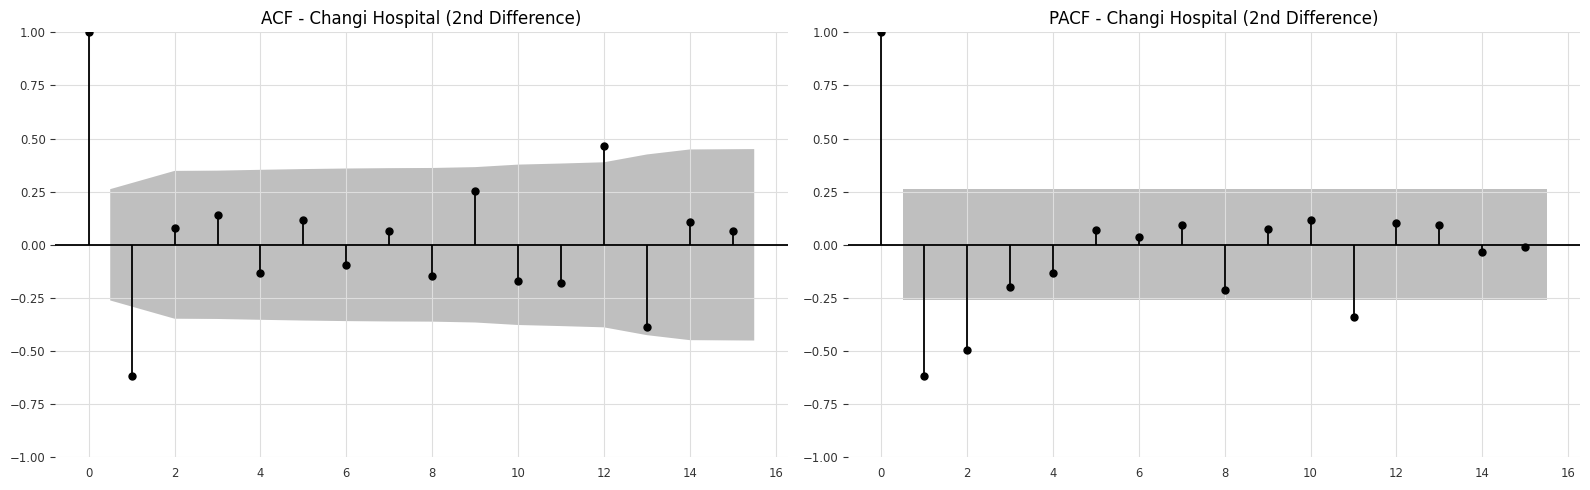

In [11]:
changi_train, changi_test = split_dataset(df, 'Changi General Hospital')

# Perform differencing to make ts stationary 
differencer_1 = Diff(lags = 1, dropna = True)
changi_train_first_diff = differencer_1.fit_transform(changi_train)

differencer_2 = Diff(lags = 1, dropna = True)
changi_train_second_diff = differencer_2.fit_transform(changi_train_first_diff)

adf_result = stationarity_test_adf(changi_train_second_diff)
print(f"p-value: {round(adf_result[1], 3)}") # d = 2 in ARIMA model 

# plot acf and pacf 
fig, axes = plt.subplots(1, 2, figsize = (16, 5))
plot_acf(changi_train_second_diff.pd_series(), lags = 15, alpha = 0.05, ax = axes[0])
axes[0].set_title("ACF - Changi Hospital (2nd Difference)")

plot_pacf(changi_train_second_diff.pd_series(), lags = 15, alpha = 0.05, ax = axes[1])
axes[1].set_title("PACF - Changi Hospital (2nd Difference)")

plt.tight_layout()
plt.show() # ARIMA(1,2,1) and ARIMA(2,2,1)

In [ ]:
# Forecast using ARIMA(1,2,1)
model = ARIMA(p = 1, d = 2, q = 1)
model.fit(changi_train)
changi_pred = model.predict(4)

changi_mae = mae(changi_pred, changi_test)
changi_mape = mape(changi_test, changi_pred)

print(f"MAE (Test Only) for ARIMA(1,2,1): {changi_mae:.2f}")
print(f"MAPE (Test Only) for ARIMA(1,2,1): {changi_mape:.2f}%\n")

# Forecast using ARIMA(2,2,1)
model = ARIMA(p = 2, d = 2, q = 1)
model.fit(changi_train)
changi_pred = model.predict(4)

changi_mae = mae(changi_pred, changi_test)
changi_mape = mape(changi_test, changi_pred)

print(f"MAE (Test Only) for ARIMA(2,2,1): {changi_mae:.2f}")
print(f"MAPE (Test Only) for ARIMA(2,2,1): {changi_mape:.2f}%\n")

MAE (Test Only) for ARIMA(1,2,1): 171.00
MAPE (Test Only) for ARIMA(1,2,1): 3.61%

MAE (Test Only) for ARIMA(2,2,1): 174.94
MAPE (Test Only) for ARIMA(2,2,1): 3.68%



In [68]:
model = ARIMA(p = 2, d = 2, q = 1)
model.fit(changi_train)
changi_pred = model.predict(4)

residuals = changi_test.pd_series() - changi_pred.pd_series()

lb_test = acorr_ljungbox(residuals.dropna(), lags = 3, return_df = True) 
print(f"p-value of Ljung-box test: {lb_test['lb_pvalue'].iloc[0]}")

p-value of Ljung-box test: 0.5189069178549526


In [13]:
changi_auto_arima = auto_arima(changi_train.pd_series(), start_p = 1, start_q = 1, max_p = 5, max_q = 5, 
                                  d = 1, max_d = 2, D = 1, max_D = 2, start_P = 0, start_Q = 0, max_P = 2, max_Q = 2,
                                  seasonal = True, information_criterion = 'aic', stepwise = True, random_state = 42, trace = True, n_fits = 50)

changi_auto_arima.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=819.482, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=801.250, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=817.518, Time=0.00 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=792.011, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=792.191, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.04 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=790.874, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=799.537, Time=0.01 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=791.530, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=790.144, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=788.962, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=788.328, Time=0.18 se

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   58
Model:               SARIMAX(0, 1, 1)   Log Likelihood                -392.164
Date:                Wed, 16 Apr 2025   AIC                            788.328
Time:                        10:09:23   BIC                            792.415
Sample:                    01-01-2020   HQIC                           789.916
                         - 10-01-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7599      0.118     -6.460      0.000      -0.990      -0.529
sigma2      5.642e+04   1.05e+04      5.360      0.000    3.58e+04     7.7e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.63   Jarque-Bera (JB):                 1.25
Prob(Q):                              0.43   Prob(JB):                         0.53
Heteroskedasticity (H):               0.53   Skew:                             0.28
Prob(H) (two-sided):                  0.18   Kurtosis:                         3.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [14]:
model = ARIMA(p = 0, d = 1, q = 1)
model.fit(changi_train)
changi_pred = model.predict(4)

changi_mae = mae(changi_pred, changi_test)
changi_mape = mape(changi_test, changi_pred)

print(f"MAE (Test Only) for ARIMA(1,2,1): {changi_mae:.2f}")
print(f"MAPE (Test Only) for ARIMA(1,2,1): {changi_mape:.2f}%\n")


MAE (Test Only) for ARIMA(1,2,1): 183.00
MAPE (Test Only) for ARIMA(1,2,1): 3.77%



### **ARIMA Forecasting (Khoo Teck Puat Hospital)**

p-value: 0.0


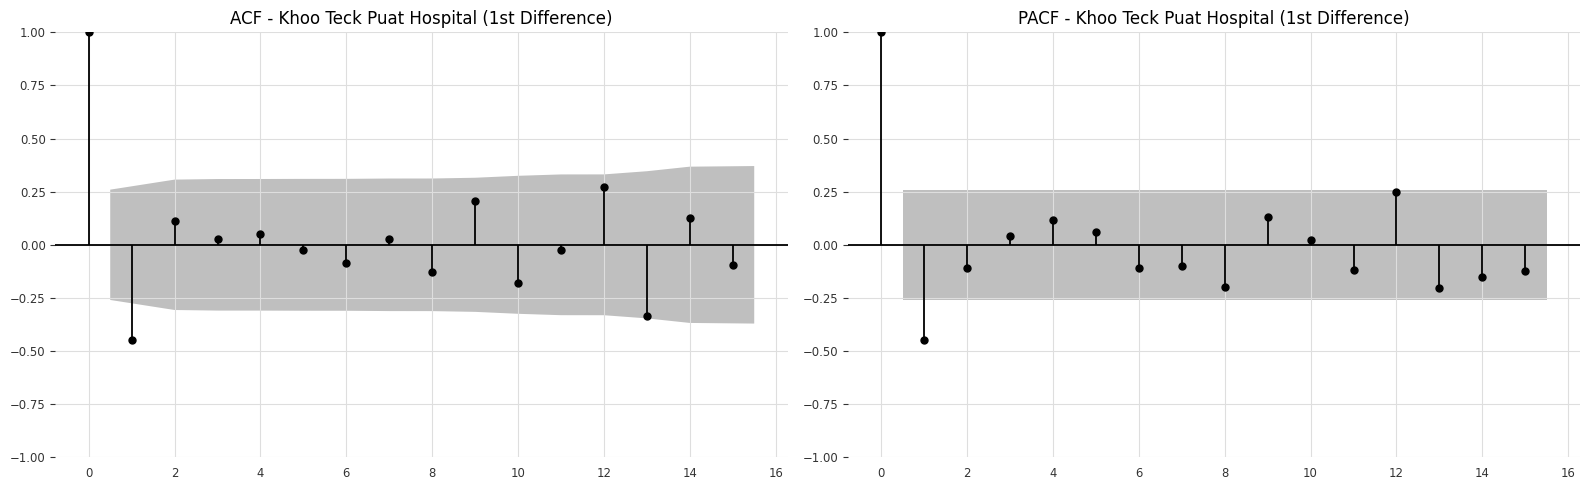

In [15]:
ktp_train, ktp_test = split_dataset(df, 'Khoo Teck Puat Hospital')

# Perform differencing to make ts stationary 
differencer_1 = Diff(lags = 1, dropna = True)
ktp_train_first_diff = differencer_1.fit_transform(ktp_train)

adf_result = stationarity_test_adf(ktp_train_first_diff)
print(f"p-value: {round(adf_result[1], 3)}") # d = 1 in ARIMA model 

# plot acf and pacf 
fig, axes = plt.subplots(1, 2, figsize = (16, 5))
plot_acf(ktp_train_first_diff.pd_series(), lags = 15, alpha = 0.05, ax = axes[0])
axes[0].set_title("ACF - Khoo Teck Puat Hospital (1st Difference)")

plot_pacf(ktp_train_first_diff.pd_series(), lags = 15, alpha = 0.05, ax = axes[1])
axes[1].set_title("PACF - Khoo Teck Puat Hospital (1st Difference)")

plt.tight_layout()
plt.show() # ARIMA(1,1,1) 

MAE (Test Only) for ARIMA(1,1,1): 99.77
MAPE (Test Only) for ARIMA(1,1,1): 2.81%



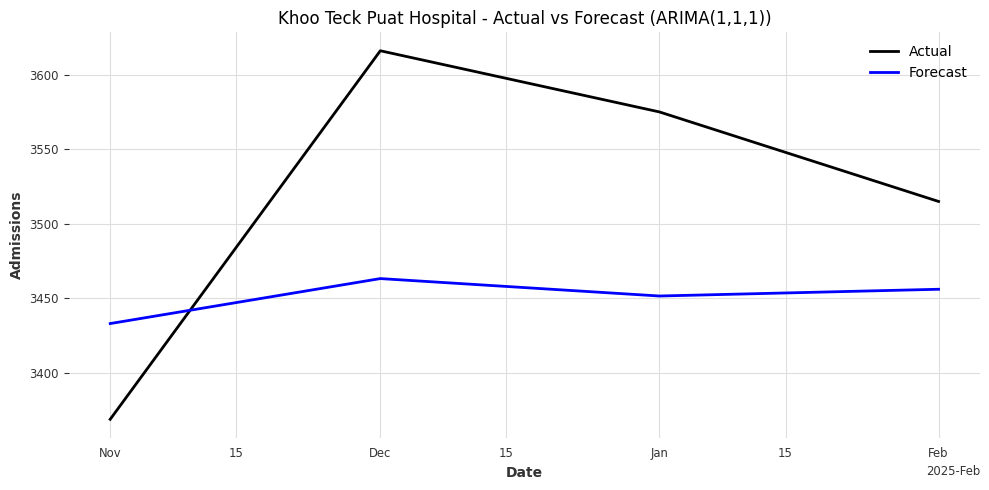

In [76]:
# Forecast using ARIMA(1,1,1)
model = ARIMA(p = 1, d = 1, q = 1)
model.fit(ktp_train)
ktp_pred = model.predict(4)

ktp_mae = mae(ktp_pred, ktp_test)
ktp_mape = mape(ktp_test, ktp_pred)

print(f"MAE (Test Only) for ARIMA(1,1,1): {ktp_mae:.2f}")
print(f"MAPE (Test Only) for ARIMA(1,1,1): {ktp_mape:.2f}%\n")

plt.figure(figsize=(10, 5))
ktp_test.plot(label="Actual", color="black")
ktp_pred.plot(label="Forecast", color="blue")
plt.title("Khoo Teck Puat Hospital - Actual vs Forecast (ARIMA(1,1,1))")
plt.xlabel("Date")
plt.ylabel("Admissions")
plt.legend()
plt.tight_layout()
plt.show()


In [16]:
ktp_auto_arima = auto_arima(ktp_train.pd_series(), start_p = 1, start_q = 1, max_p = 5, max_q = 5, 
                                  d = 1, max_d = 2, D = 1, max_D = 2, start_P = 0, start_Q = 0, max_P = 2, max_Q = 2,
                                  seasonal = True, information_criterion = 'aic', stepwise = True, random_state = 42, trace = True, n_fits = 50)

ktp_auto_arima.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=779.824, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=795.696, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=779.483, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=780.568, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=793.735, Time=0.00 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=779.286, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=781.249, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=781.270, Time=0.04 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=782.980, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=777.289, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=777.497, Time=0.01 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=779.254, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=779.273, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=777.826, Time=0.01 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=780.9

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   58
Model:               SARIMAX(2, 1, 0)   Log Likelihood                -385.644
Date:                Wed, 16 Apr 2025   AIC                            777.289
Time:                        10:12:07   BIC                            783.418
Sample:                    01-01-2020   HQIC                           779.671
                         - 10-01-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6737      0.121     -5.561      0.000      -0.911      -0.436
ar.L2         -0.2122      0.138     -1.542      0.123      -0.482       0.057
sigma2      4.596e+04   7139.740      6.437      0.000     3.2e+04       6e+04
===================================================================================
Ljung-Box (L1) (Q):                   1.07   Jarque-Bera (JB):                 6.13
Prob(Q):                              0.30   Prob(JB):                         0.05
Heteroskedasticity (H):               0.97   Skew:                            -0.67
Prob(H) (two-sided):                  0.95   Kurtosis:                         3.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [17]:
model = ARIMA(p = 2, d = 1, q = 0)
model.fit(ktp_train)
ktp_pred = model.predict(4)

ktp_mae = mae(ktp_pred, ktp_test)
ktp_mape = mape(ktp_test, ktp_pred)

print(f"MAE (Test Only) for ARIMA(2,1,0): {ktp_mae:.2f}")
print(f"MAPE (Test Only) for ARIMA(2,1,0): {ktp_mape:.2f}%\n")

MAE (Test Only) for ARIMA(2,1,0): 104.50
MAPE (Test Only) for ARIMA(2,1,0): 2.94%



### **ARIMA Forecasting (National University Hospital)**

p-value: 0.043


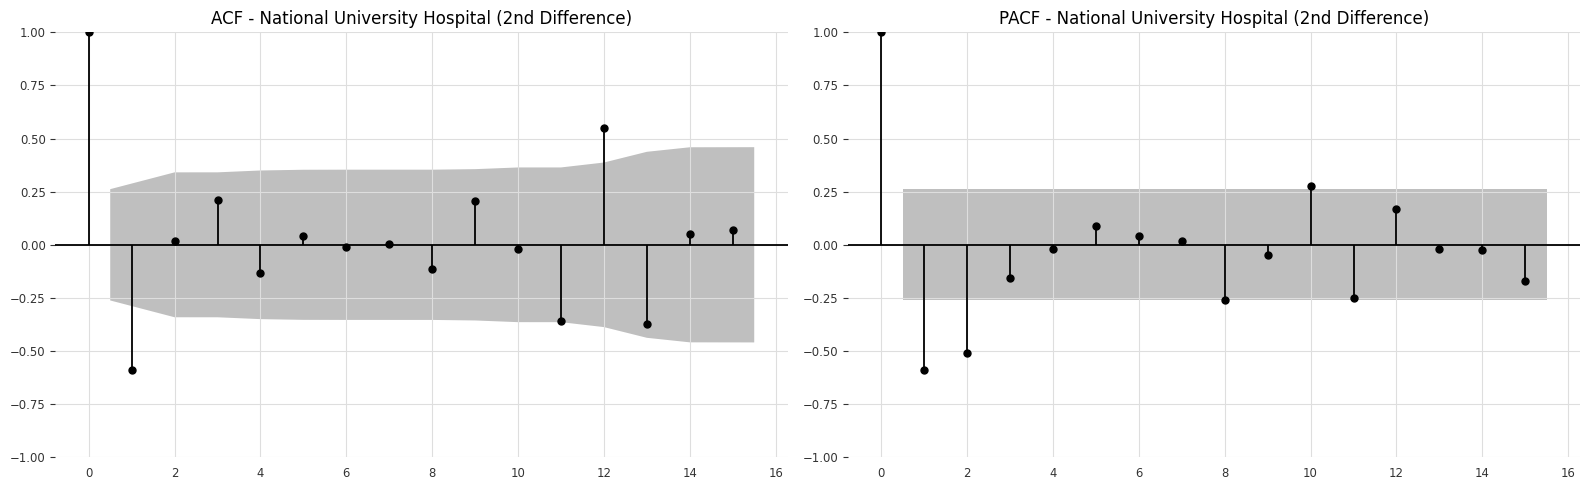

In [18]:
nuh_train, nuh_test = split_dataset(df, 'National University Hospital')

# Perform differencing to make ts stationary 
differencer_1 = Diff(lags = 1, dropna = True)
nuh_train_first_diff = differencer_1.fit_transform(nuh_train)

differencer_2 = Diff(lags = 1, dropna = True)
nuh_train_second_diff = differencer_2.fit_transform(nuh_train_first_diff)

adf_result = stationarity_test_adf(nuh_train_second_diff)
print(f"p-value: {round(adf_result[1], 3)}") # d = 2 in ARIMA model 

# plot acf and pacf 
fig, axes = plt.subplots(1, 2, figsize = (16, 5))
plot_acf(nuh_train_second_diff.pd_series(), lags = 15, alpha = 0.05, ax = axes[0])
axes[0].set_title("ACF - National University Hospital (2nd Difference)")

plot_pacf(nuh_train_second_diff.pd_series(), lags = 15, alpha = 0.05, ax = axes[1])
axes[1].set_title("PACF - National University Hospital (2nd Difference)")

plt.tight_layout()
plt.show() # ARIMA(1,2,1) or ARIMA(2,2,1) 

In [ ]:
# Forecast using ARIMA(1,2,1)
model = ARIMA(p = 1, d = 2, q = 1)
model.fit(nuh_train)
nuh_pred = model.predict(4)

nuh_mae = mae(nuh_pred, nuh_test)
nuh_mape = mape(nuh_test, nuh_pred)

print(f"MAE (Test Only) for ARIMA(1,2,1): {nuh_mae:.2f}")
print(f"MAPE (Test Only) for ARIMA(1,2,1): {nuh_mape:.2f}%\n")

# Forecast using ARIMA(2,2,1)
model = ARIMA(p = 2, d = 2, q = 1)
model.fit(nuh_train)
nuh_pred = model.predict(4)

nuh_mae = mae(nuh_pred, nuh_test)
nuh_mape = mape(nuh_test, nuh_pred)

print(f"MAE (Test Only) for ARIMA(2,2,1): {nuh_mae:.2f}")
print(f"MAPE (Test Only) for ARIMA(2,2,1): {nuh_mape:.2f}%\n")

MAE (Test Only) for ARIMA(1,2,1): 212.13
MAPE (Test Only) for ARIMA(1,2,1): 3.56%

MAE (Test Only) for ARIMA(2,2,1): 184.39
MAPE (Test Only) for ARIMA(2,2,1): 3.11%



In [19]:
nuh_auto_arima = auto_arima(nuh_train.pd_series(), start_p = 1, start_q = 1, max_p = 5, max_q = 5, 
                                  d = 1, max_d = 2, D = 1, max_D = 2, start_P = 0, start_Q = 0, max_P = 2, max_Q = 2,
                                  seasonal = True, information_criterion = 'aic', stepwise = True, random_state = 42, trace = True, n_fits = 50)

nuh_auto_arima.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=846.485, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=833.026, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=844.499, Time=0.00 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=829.138, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=830.248, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.04 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=827.540, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=831.169, Time=0.01 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=828.902, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=825.529, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=823.530, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=821.537, Time=0.01 se

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   58
Model:               SARIMAX(0, 1, 1)   Log Likelihood                -408.769
Date:                Wed, 16 Apr 2025   AIC                            821.537
Time:                        10:18:06   BIC                            825.624
Sample:                    01-01-2020   HQIC                           823.125
                         - 10-01-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7416      0.119     -6.257      0.000      -0.974      -0.509
sigma2      1.055e+05   2.05e+04      5.138      0.000    6.52e+04    1.46e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.11   Jarque-Bera (JB):                 0.09
Prob(Q):                              0.73   Prob(JB):                         0.95
Heteroskedasticity (H):               0.32   Skew:                            -0.07
Prob(H) (two-sided):                  0.02   Kurtosis:                         2.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [20]:
model = ARIMA(p = 0, d = 1, q = 1)
model.fit(nuh_train)
nuh_pred = model.predict(4)

nuh_mae = mae(nuh_pred, nuh_test)
nuh_mape = mape(nuh_test, nuh_pred)

print(f"MAE (Test Only) for ARIMA(0,1,1): {nuh_mae:.2f}")
print(f"MAPE (Test Only) for ARIMA(0,1,1): {nuh_mape:.2f}%\n")

MAE (Test Only) for ARIMA(0,1,1): 150.85
MAPE (Test Only) for ARIMA(0,1,1): 2.54%



### **ARIMA Forecasting (Sengkang General Hospital)**

p-value: 0.045


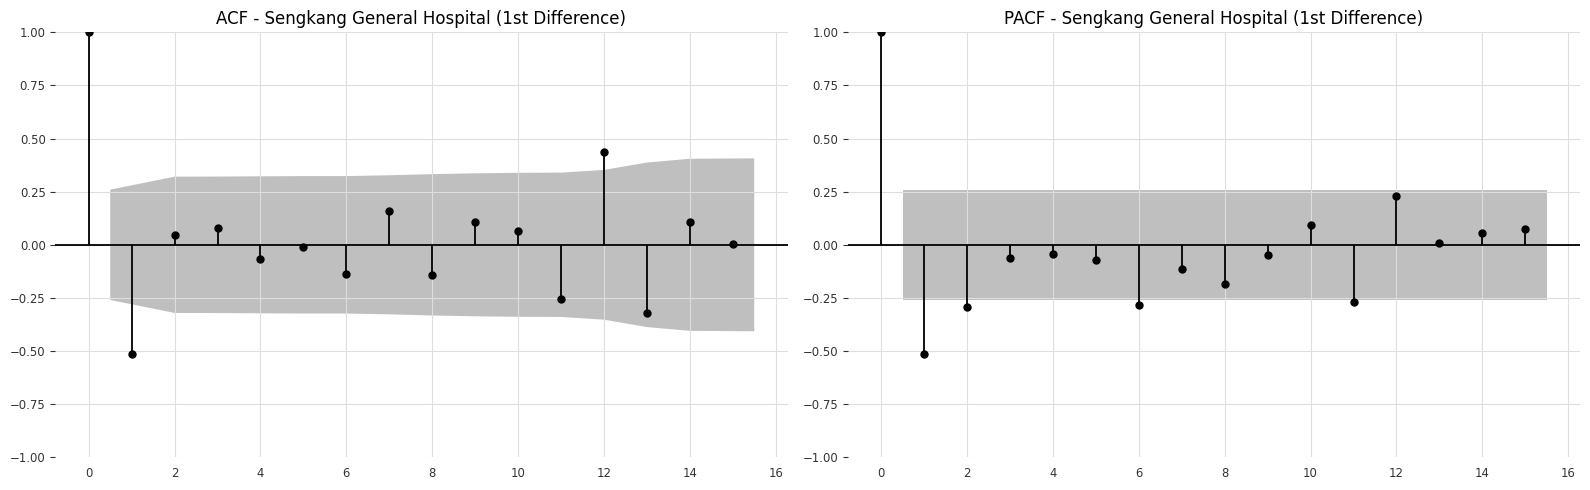

In [22]:
sgh_train, sgh_test = split_dataset(df, 'Sengkang General Hospital')

# Perform differencing to make ts stationary 
differencer_1 = Diff(lags = 1, dropna = True)
sgh_train_first_diff = differencer_1.fit_transform(sgh_train)

adf_result = stationarity_test_adf(sgh_train_first_diff)
print(f"p-value: {round(adf_result[1], 3)}") # d = 1 in ARIMA model 

# plot acf and pacf 
fig, axes = plt.subplots(1, 2, figsize = (16, 5))
plot_acf(sgh_train_first_diff.pd_series(), lags = 15, alpha = 0.05, ax = axes[0])
axes[0].set_title("ACF - Sengkang General Hospital (1st Difference)")

plot_pacf(sgh_train_first_diff.pd_series(), lags = 15, alpha = 0.05, ax = axes[1])
axes[1].set_title("PACF - Sengkang General Hospital (1st Difference)")

plt.tight_layout()
plt.show() # ARIMA(1,1,1) or ARIMA(2,1,1) 

In [13]:
# Forecast using ARIMA(1,1,1)
model = ARIMA(p = 1, d = 1, q = 1)
model.fit(sgh_train)
sgh_pred = model.predict(4)

sgh_mae = mae(sgh_pred, sgh_test)
sgh_mape = mape(sgh_test, sgh_pred)

print(f"MAE (Test Only) for ARIMA(1,1,1): {sgh_mae:.2f}")
print(f"MAPE (Test Only) for ARIMA(1,1,1): {sgh_mape:.2f}%\n")

# Forecast using ARIMA(2,1,1)
model = ARIMA(p = 2, d = 1, q = 1)
model.fit(sgh_train)
sgh_pred = model.predict(4)

sgh_mae = mae(sgh_pred, sgh_test)
sgh_mape = mape(sgh_test, sgh_pred)

print(f"MAE (Test Only) for ARIMA(2,1,1): {sgh_mae:.2f}")
print(f"MAPE (Test Only) for ARIMA(2,1,1): {sgh_mape:.2f}%\n")

MAE (Test Only) for ARIMA(1,1,1): 93.03
MAPE (Test Only) for ARIMA(1,1,1): 2.02%

MAE (Test Only) for ARIMA(2,1,1): 91.25
MAPE (Test Only) for ARIMA(2,1,1): 1.98%



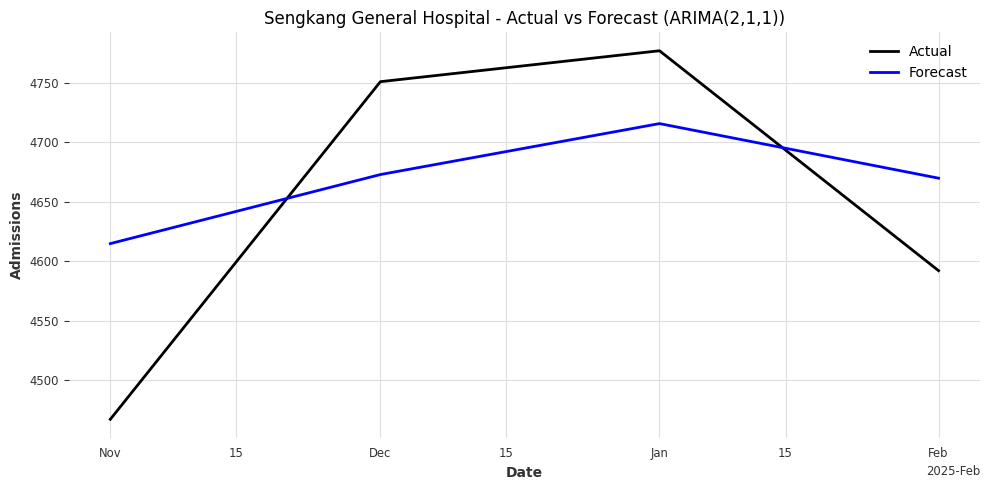

In [15]:
plt.figure(figsize=(10, 5))
sgh_test.plot(label="Actual", color="black")
sgh_pred.plot(label="Forecast", color="blue")
plt.title("Sengkang General Hospital - Actual vs Forecast (ARIMA(2,1,1))")
plt.xlabel("Date")
plt.ylabel("Admissions")
plt.legend()
plt.tight_layout()
plt.show()

In [23]:
sgh_auto_arima = auto_arima(sgh_train.pd_series(), start_p = 1, start_q = 1, max_p = 5, max_q = 5, 
                                  d = 1, max_d = 2, D = 1, max_D = 2, start_P = 0, start_Q = 0, max_P = 2, max_Q = 2,
                                  seasonal = True, information_criterion = 'aic', stepwise = True, random_state = 42, trace = True, n_fits = 50)

sgh_auto_arima.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=809.484, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=787.831, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=807.821, Time=0.00 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=783.348, Time=0.01 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=784.944, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=786.940, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=784.203, Time=0.01 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0] intercept
Total fit time: 0.234 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   58
Model:               SARIMAX(2, 1, 0)   Log Likelihood                -387.674
Date:                Wed, 16 Apr 2025   AIC                            783.348
Time:                        10:23:11   BIC                            791.520
Sample:                    01-01-2020   HQIC                           786.524
                         - 10-01-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     51.8422     32.191      1.610      0.107     -11.250     114.935
ar.L1         -0.7999      0.140     -5.701      0.000      -1.075      -0.525
ar.L2         -0.3486      0.137     -2.544      0.011      -0.617      -0.080
sigma2      4.838e+04   1.18e+04      4.096      0.000    2.52e+04    7.15e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                 1.92
Prob(Q):                              0.84   Prob(JB):                         0.38
Heteroskedasticity (H):               0.59   Skew:                             0.13
Prob(H) (two-sided):                  0.26   Kurtosis:                         2.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [24]:
model = ARIMA(p = 2, d = 1, q = 0)
model.fit(sgh_train)
sgh_pred = model.predict(4)

sgh_mae = mae(sgh_pred, sgh_test)
sgh_mape = mape(sgh_test, sgh_pred)

print(f"MAE (Test Only) for ARIMA(2,1,0): {sgh_mae:.2f}")
print(f"MAPE (Test Only) for ARIMA(2,1,0): {sgh_mape:.2f}%\n")

MAE (Test Only) for ARIMA(2,1,0): 88.18
MAPE (Test Only) for ARIMA(2,1,0): 1.92%

